In [5]:
import pandas as pd

# Load datasets
marketing_df = pd.read_csv('Assignment3-Marketing-Dataset.csv')
unknown_df = pd.read_csv('Assignment3-Unknown-Dataset.csv')

#Replace values '?' with NaN
marketing_df.replace('?', pd.NA, inplace=True)
unknown_df.replace('?', pd.NA, inplace=True)



In [6]:
# Basic exploration
print("Marketing dataset shape:", marketing_df.shape)

# Display first few rows
print("\nMarketing data first 5 rows:")
print(marketing_df.head())

# Check data types
print("\nMarketing data types:")
print(marketing_df.dtypes)

# Check for missing values per column
print("\nMissing values per column:")
print(marketing_df.isnull().sum())


Marketing dataset shape: (26360, 23)

Marketing data first 5 rows:
  row ID  age          job  marital            education  default housing  \
0   Row0   56    housemaid  married             basic.4y       no      no   
1   Row1   56     services  married          high.school       no      no   
2   Row2   45     services  married             basic.9y  unknown      no   
3   Row3   59       admin.  married  professional.course       no      no   
4   Row4   41  blue-collar  married              unknown  unknown      no   

  loan    contact month  ... pdays  previous     poutcome emp.var.rate  \
0   no  telephone   may  ...   999         0  nonexistent          1.1   
1  yes  telephone   may  ...   999         0  nonexistent          1.1   
2   no  telephone   may  ...   999         0  nonexistent          1.1   
3   no  telephone   may  ...   999         0  nonexistent          1.1   
4   no  telephone   may  ...   999         0  nonexistent          1.1   

   cons.price.idx cons.co

In [7]:
# List of numeric columns stored as objects
numeric_objects = [
    'pdays', 'emp.var.rate', 'cons.price.idx',
    'cons.conf.idx', 'euribor3m', 'nr.employed'
]

# Convert them to numeric type
for col in numeric_objects:
    marketing_df[col] = pd.to_numeric(marketing_df[col])

# Check to confirm
print(marketing_df[numeric_objects].dtypes)


pdays             float64
emp.var.rate      float64
cons.price.idx    float64
cons.conf.idx     float64
euribor3m         float64
nr.employed       float64
dtype: object


In [8]:
# Identify categorical columns (object types)
categorical_cols = marketing_df.select_dtypes(include='object').columns

# Replace 'unknown' with 'missing' in all categorical columns
for col in categorical_cols:
    marketing_df[col] = marketing_df[col].replace('unknown', '')

print(marketing_df.head())


  row ID  age          job  marital            education default housing loan  \
0   Row0   56    housemaid  married             basic.4y      no      no   no   
1   Row1   56     services  married          high.school      no      no  yes   
2   Row2   45     services  married             basic.9y              no   no   
3   Row3   59       admin.  married  professional.course      no      no   no   
4   Row4   41  blue-collar  married                                   no   no   

     contact month  ...  pdays  previous     poutcome  emp.var.rate  \
0  telephone   may  ...  999.0         0  nonexistent           1.1   
1  telephone   may  ...  999.0         0  nonexistent           1.1   
2  telephone   may  ...  999.0         0  nonexistent           1.1   
3  telephone   may  ...  999.0         0  nonexistent           1.1   
4  telephone   may  ...  999.0         0  nonexistent           1.1   

   cons.price.idx cons.conf.idx  euribor3m  nr.employed  state  subscribed  
0        

In [11]:
#Separate values
X = marketing_df.drop(columns=['row ID', 'subscribed'])
y = marketing_df['subscribed']

# Separate column types
categorical_features = X.select_dtypes(include='object').columns.tolist()
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

In [12]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),      # Handle numeric missing values
    ('scaler', StandardScaler())                        # Normalize numeric values
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Fill missing category
    ('onehot', OneHotEncoder(handle_unknown='ignore'))     # Transform categories to binary vectors
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

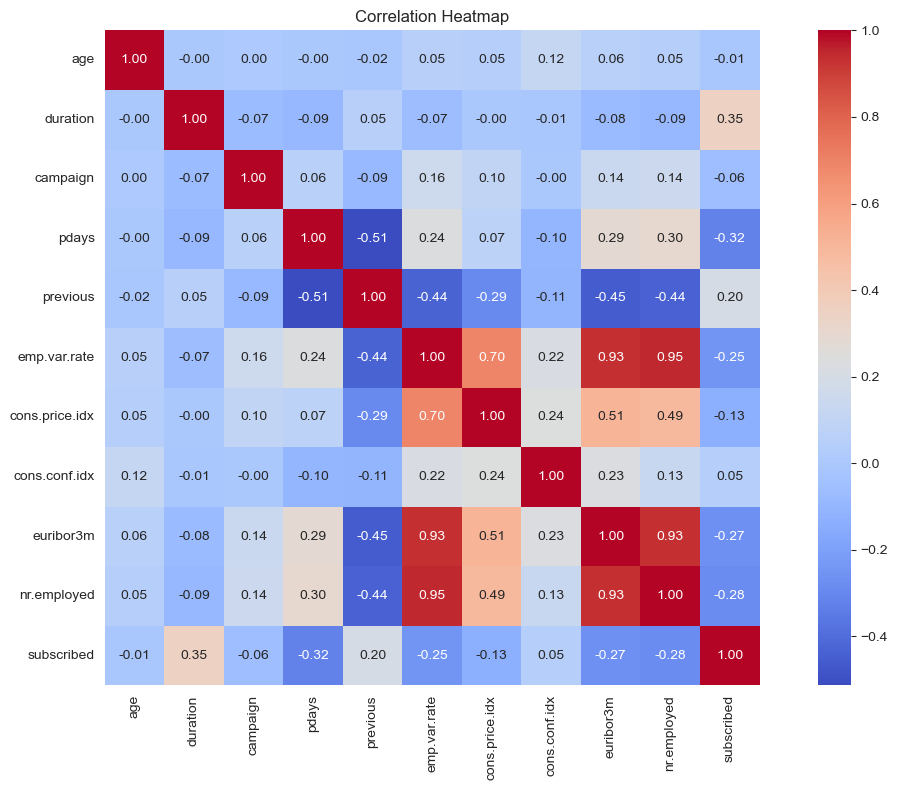

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select only numeric columns
numeric_cols = marketing_df.select_dtypes(include=['int64', 'float64'])

# Compute Spearman correlation
corr_matrix = numeric_cols.corr(method='spearman')

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()


In [14]:
from sklearn.model_selection import train_test_split


# 1. Split the dataset
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [15]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, confusion_matrix, roc_curve


def run_model_pipeline(model, model_name):
    from sklearn.pipeline import Pipeline
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    pipeline.fit(X_train, y_train)

    # Training predictions
    y_train_pred = pipeline.predict(X_train)
    y_val_pred = pipeline.predict(X_val)
    y_train_prob = pipeline.predict_proba(X_train)[:, 1]
    y_val_prob = pipeline.predict_proba(X_val)[:, 1]

    # Metrics function
    def get_metrics(y_true, y_pred, y_prob):
        cm = confusion_matrix(y_true, y_pred)
        TN, FP, FN, TP = cm.ravel()
        return {
            'Accuracy': accuracy_score(y_true, y_pred),
            'Recall': recall_score(y_true, y_pred),
            'Precision': precision_score(y_true, y_pred),
            'F1 Score': f1_score(y_true, y_pred),
            'Sensitivity': recall_score(y_true, y_pred),
            'Specificity': TN / (TN + FP),
            'AUC': roc_auc_score(y_true, y_prob),
            'Confusion Matrix': cm
        }

    train_metrics = get_metrics(y_train, y_train_pred, y_train_prob)
    val_metrics = get_metrics(y_val, y_val_pred, y_val_prob)

    print(f"\n{model_name}")
    print("\nTraining Metrics:")
    for k, v in train_metrics.items():
        if k != 'Confusion Matrix':
            print(f"{k}: {v:.4f}")
    print("Confusion Matrix:\n", train_metrics['Confusion Matrix'])

    print("\nValidation Metrics:")
    for k, v in val_metrics.items():
        if k != 'Confusion Matrix':
            print(f"{k}: {v:.4f}")
    print("Confusion Matrix:\n", val_metrics['Confusion Matrix'])

    # ROC Curve
    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_prob)
    fpr_val, tpr_val, _ = roc_curve(y_val, y_val_prob)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(fpr_train, tpr_train, label='Train')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title(f'Train ROC - {model_name}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.grid(True)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(fpr_val, tpr_val, label='Validation')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title(f'Validation ROC - {model_name}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    #Generate Kaggle submission file
    X_unknown = unknown_df.drop(columns=['row ID'])
    kaggle_preds = pipeline.predict(X_unknown)

    submission_df = pd.DataFrame({
        'row ID': unknown_df['row ID'],
        'Prediction-subscribed': kaggle_preds
    })
    file_name = f'kaggle_submission_{model_name.lower().replace(" ", "_")}.csv'
    submission_df.to_csv(file_name, index=False)
    print(f"Kaggle submission file saved as: {file_name}")



In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline


dt_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

dt_param_grid = {
    'classifier__max_depth': [5, 10, 15, 20],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__criterion': ['gini', 'entropy']
}

dt_grid = GridSearchCV(dt_pipeline, dt_param_grid, cv=5, scoring='f1', n_jobs=-1)
dt_grid.fit(X_train, y_train)

best_dt = dt_grid.best_estimator_
run_model_pipeline(best_dt.named_steps['classifier'], "Decision Tree")


In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(
    n_neighbors=5,
    weights='distance',
    metric='euclidean'
)

run_model_pipeline(knn, "K-Nearest Neighbors")


In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

rf_param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [10, 15, 20],
    'classifier__max_features': ['sqrt', 'log2'],
    'classifier__class_weight': ['balanced']
}

rf_grid = GridSearchCV(rf_pipeline, rf_param_grid, cv=5, scoring='f1', n_jobs=-1)
rf_grid.fit(X_train, y_train)

best_rf = rf_grid.best_estimator_
run_model_pipeline(best_rf.named_steps['classifier'], "Random Forest")


In [ ]:
from sklearn.svm import SVC

svm_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', SVC(probability=True, random_state=42))
])

svm_param_grid = {
    'classifier__C': [0.1, 1, 10],
    'classifier__gamma': ['scale', 'auto'],
    'classifier__kernel': ['rbf'],
    'classifier__class_weight': ['balanced']
}

svm_grid = GridSearchCV(svm_pipeline, svm_param_grid, cv=5, scoring='f1', n_jobs=-1)
svm_grid.fit(X_train, y_train)

best_svm = svm_grid.best_estimator_
run_model_pipeline(best_svm.named_steps['classifier'], "SVM")



In [ ]:
from sklearn.neural_network import MLPClassifier

mlp_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', MLPClassifier(max_iter=300, random_state=42))
])

mlp_param_grid = {
    'classifier__hidden_layer_sizes': [(100,), (100, 50), (50, 30, 10)],
    'classifier__alpha': [0.0001, 0.001, 0.01],
    'classifier__solver': ['adam'],
    'classifier__activation': ['relu', 'tanh']
}

mlp_grid = GridSearchCV(mlp_pipeline, mlp_param_grid, cv=5, scoring='f1', n_jobs=-1)
mlp_grid.fit(X_train, y_train)

best_mlp = mlp_grid.best_estimator_
run_model_pipeline(best_mlp.named_steps['classifier'], " Neural Network")
